In [ ]:
"""
Use this notebook to train/test/evaluate Deep Learning for signal ID
TRAINED ON GOOGLE COLAB PRO TO ENABLE GPUs and speed up training time
"""
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys
print(sys.version)
from keras import layers
from keras.preprocessing.image import load_img
import cv2

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Num GPUs Available:  1


In [ ]:
os.chdir("..")
os.chdir(os. getcwd() + "\\src")
from c import ROOT_DIR

In [ ]:
"""
HRNet model

https://arxiv.org/abs/1908.07919
https://arxiv.org/pdf/1908.07919.pdf
"""

import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    # x = BatchNormalization(axis=3)(x)
    # x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))

    x = stem_net(inputs)

    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model

In [ ]:
"""
metrtics
"""
import numpy as np
import keras.backend as K


def _true_positives(y_true, y_pred):
    # determine number of matching values and return the sum
    if K.is_tensor(y_pred):
        return K.sum(y_true * K.round(y_pred))
    else:
        return (y_true * np.round(y_pred)).sum()


def _true_negatives(y_true, y_pred):
    # invert and then treat as true positives
    y_true = (y_true - 1) * -1
    y_pred = (y_pred - 1) * -1

    return _true_positives(y_true, y_pred)


def _false_negatives(y_true, y_pred):
    if K.is_tensor(y_pred):
        return K.sum(K.clip((y_true - K.round(y_pred)), 0, 1))
    else:
        return (y_true - np.round(y_pred)).clip(0).sum()


def _false_positives(y_true, y_pred):
    # switch positions and treat as false negatives
    return _false_negatives(y_pred, y_true)


def _calc_mean_metric(y_true, y_pred, metric, starting_label=0):
    switcher = {
        'mPrec': precision,
        # TODO 'mAP': average_precision,
        'mf1': f1,
        'mAcc': accuracy,
        'mBacc': balanced_accuracy,
        'mRec': recall,
        'mIOU': iou,
        'mSpec': specificity,
        'mMcc': mcc
    }

    try:
        func = switcher[metric]
    except KeyError:
        raise ValueError('Unkown Metric')

    if K.is_tensor(y_true):
        amount_labels = K.int_shape(y_pred)[-1]
        batch_size = K.int_shape(y_pred)[0]
        summation = K.variable(0)
        y_pred = K.round(y_pred)
    else:
        amount_labels = y_pred.shape[-1]
        batch_size = y_pred.shape[0]
        summation = 0

    for batch_num in range(batch_size):
        for label in range(starting_label, amount_labels):
            summation = summation + func(
                y_true[batch_num, :, :, label], y_pred[batch_num, :, :, label])

    return summation / (batch_size * amount_labels)


def recall(y_true, y_pred):
    # Recall = TP / P
    if K.is_tensor(y_pred):
        return _true_positives(y_true, y_pred) / K.sum(y_true)
    else:
        return _true_positives(y_true, y_pred) / y_true.sum()


def specificity(y_true, y_pred):
    # Specificity = TN / N = TN / (TN + FN)
    return _true_positives(y_true, y_pred) / (
            _true_negatives(y_true, y_pred) +
            _false_negatives(y_true, y_pred))


def precision(y_true, y_pred):
    # Precision = TP / (TP + FP)
    tp = _true_positives(y_true, y_pred)
    return tp / (tp + _false_negatives(y_true, y_pred))

def iou(y_true, y_pred):
    """homemade IOU"""
    # IOU = TP / (TP + FN + FP)
    smooth = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
  

# def iou(y_true, y_pred):
#     # IOU = TP / (TP + FN + FP)
#     I = _true_positives(y_true, y_pred)
#     U = I + _false_negatives(y_true, y_pred) + _false_positives(y_true, y_pred)

#     if K.is_tensor(y_pred):
#         return K.switch(K.equal(U, 0), 1.0, I / U)
#     else:
#         return 1 if U is 0 else I / U


def balanced_accuracy(y_true, y_pred):
    # BA = (TPR + TNR) / 2 = (Recall + Specificity) / 2
    return (recall(y_true, y_pred) + specificity(y_true, y_pred)) / 2


def f1(y_true, y_pred):
    # F1 2 * prec * rec / (prec + rec)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec / (prec + rec))


def mcc(y_true, y_pred):
    # mcc = https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    tp = _true_positives(y_true, y_pred)
    fp = _false_positives(y_true, y_pred)
    tn = _true_negatives(y_true, y_pred)
    fn = _false_negatives(y_true, y_pred)
    num = tp * tn - fp * fn
    den = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return num / den


def accuracy(y_true, y_pred):
    # acc = (tp + tn) / tp + fp + tn + fn
    tp = _true_positives(y_true, y_pred)
    fp = _false_positives(y_true, y_pred)
    tn = _true_negatives(y_true, y_pred)
    fn = _false_negatives(y_true, y_pred)

    return (tp + tn) / tp + fp + tn + fn


def mean_mcc(y_true, y_pred):
    """ Calculates the mean accuracy of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean accuracy
    """
    return _calc_mean_metric(y_true, y_pred, 'mMcc')


def mean_accuracy(y_true, y_pred):
    """ Calculates the mean accuracy of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean accuracy
    """
    return _calc_mean_metric(y_true, y_pred, 'mAcc')


def mean_iou(y_true, y_pred):
    """" Calculates the mean IOU of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean IOU
    """
    return _calc_mean_metric(y_true, y_pred, 'mIOU')


def mean_precision(y_true, y_pred):
    """ Calculates the mean precision of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean precision
    """
    return _calc_mean_metric(y_true, y_pred, 'mPrec')


def mean_recall(y_true, y_pred):
    """ Calculates the mean recall of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean recall
    """
    return _calc_mean_metric(y_true, y_pred, 'mRec')


# def mean_average_precision(gt, pred, colours=[[0,0,0], [255,255,255]]):
#     """ Calculates the mean recall of two images for given colours.

#     # Arguments:
#         See parameters in :func:`_calc_mean_metric`

#     # Returns:
#         The mean average precision
#     """
#     return _calc_mean_metric(gt, pred, colours, 'mAP')

def mean_f1(y_true, y_pred):
    """ Calculates the mean f1 score.
    Currently calculates f1 score for each colour and then averages that. Can be calculated in many ways,
    see: http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean f1 score
    """
    return _calc_mean_metric(y_true, y_pred, 'mf1')


def mean_balanced_accuracy(y_true, y_pred):
    """ Calculates the mean f1 score.
    Currently calculates f1 score for each colour and then averages that. Can be calculated in many ways,
    see: http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean f1 score
    """
    return _calc_mean_metric(y_true, y_pred, 'mBacc')


def mean_specificity(y_true, y_pred):
    """ Calculates the mean specificity of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean specificity
    """
    return _calc_mean_metric(y_true, y_pred, 'mSpec')

In [ ]:
"""
Loss
"""

#import tensorflow as tf
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))
    loss = 1. - 2 * intersection / (union + K.epsilon())
    return loss


def ce_dice_loss(y_true, y_pred):
    ce_loss = binary_crossentropy(y_true, y_pred)

    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))
    dice_loss = - tf.log((intersection + K.epsilon()) / (union + K.epsilon()))
    loss = ce_loss + dice_loss
    return loss


def jaccard_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    loss = 1. - intersection / (union + K.epsilon())
    return loss


def ce_jaccard_loss(y_true, y_pred):
    ce_loss = binary_crossentropy(y_true, y_pred)

    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    jaccard_loss = - tf.math.log((intersection + K.epsilon()) / (union + K.epsilon()))
    loss = ce_loss + jaccard_loss
    return loss


def tversky_loss(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return 1 - (true_pos + K.epsilon())/(true_pos + alpha * false_neg + (1-alpha) * false_pos + K.epsilon())


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
"""
Add Drive for dataset
"""
# local

#mask_path = ROOT_DIR + "\\MLdata\\masks\\"
#image_path = ROOT_DIR + "\\MLdata\\das\\"


""

# connect dataset to google drive

from google.colab import drive
drive.mount('/content/drive/')


# once mounted, use these paths

image_path = '/content/drive/MyDrive/DAS_ML_data/das/'
mask_path = '/content/drive/MyDrive/DAS_ML_data/masks/'

Mounted at /content/drive/


In [ ]:
"""
Our dataloader
"""

input_dir = image_path
target_dir = mask_path

input_img_paths = sorted(
    [
        os.path.join(os.sep, input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(os.sep, target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 928
/content/drive/MyDrive/DAS_ML_data/das/0.png | /content/drive/MyDrive/DAS_ML_data/masks/0.png
/content/drive/MyDrive/DAS_ML_data/das/1.png | /content/drive/MyDrive/DAS_ML_data/masks/1.png
/content/drive/MyDrive/DAS_ML_data/das/10.png | /content/drive/MyDrive/DAS_ML_data/masks/10.png
/content/drive/MyDrive/DAS_ML_data/das/100.png | /content/drive/MyDrive/DAS_ML_data/masks/100.png
/content/drive/MyDrive/DAS_ML_data/das/101.png | /content/drive/MyDrive/DAS_ML_data/masks/101.png
/content/drive/MyDrive/DAS_ML_data/das/102.png | /content/drive/MyDrive/DAS_ML_data/masks/102.png
/content/drive/MyDrive/DAS_ML_data/das/103.png | /content/drive/MyDrive/DAS_ML_data/masks/103.png
/content/drive/MyDrive/DAS_ML_data/das/104.png | /content/drive/MyDrive/DAS_ML_data/masks/104.png
/content/drive/MyDrive/DAS_ML_data/das/105.png | /content/drive/MyDrive/DAS_ML_data/masks/105.png
/content/drive/MyDrive/DAS_ML_data/das/106.png | /content/drive/MyDrive/DAS_ML_data/masks/106.png


In [ ]:
class SeismicEventDataLoader(keras.utils.Sequence):
    """
    Helper to iterate over data as Numpy arrays.
    https://keras.io/examples/vision/oxford_pets_image_segmentation/

    """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, n_classes):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.n_classes = n_classes

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def one_hot_data(self, image):
    
        # reduce unique values down to number of classes
        result = self.kmeans_color_quantization(image, clusters=3) # should spit out 8
        result_g = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        one_hot = np.zeros((result.shape[0], result.shape[1], self.n_classes))
        for i, unique_value in enumerate(np.unique(result_g)):

            one_hot[:, :, i][result_g == unique_value] = 1

        return one_hot
    
    def kmeans_color_quantization(self, image, clusters=8, rounds=1):
        h, w = image.shape[:2]
        samples = np.zeros([h*w,3], dtype=np.float32)
        count = 0

        for x in range(h):
            for y in range(w):
                samples[count] = image[x][y]
                count += 1

        compactness, labels, centers = cv2.kmeans(samples,
                clusters, 
                None,
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
                rounds, 
                cv2.KMEANS_RANDOM_CENTERS)

        centers = np.uint8(centers)
        res = centers[labels.flatten()]
        return res.reshape((image.shape))
    
    def __getitem__(self, idx):

        """Returns tuple (input, target) correspond to batch #idx."""

        i = idx * self.batch_size
        
        h = self.img_size[0]
        w = self.img_size[1]
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j, path in enumerate(batch_input_img_paths):

            img = cv2.imread(path)
            
            height = img.shape[0]
            width = img.shape[1]
            channels = img.shape[2]
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (self.n_classes,), dtype="float32")

        for j, path in enumerate(batch_target_img_paths):
            
            img = cv2.imread(path)
            
            height = img.shape[0]
            width = img.shape[1]
            channels = img.shape[2]
            y[j] = self.one_hot_data(img)
            
        #print(np.shape(x), np.shape(y))
        
        return x, y

In [ ]:
import random

#img_size = (256, 256) # a lot faster!
img_size = (512, 512) # not as fast, but accurate

num_classes = 3
batch_size = 4 # 2 prior #4 #8 deafult #, 16 worked well for 256,256 ...32 before, OOM

# Split our img paths into a training and a validation set
val_samples = 250 #500 #100 before
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SeismicEventDataLoader(batch_size, img_size, train_input_img_paths, train_target_img_paths, num_classes)
val_gen = SeismicEventDataLoader(batch_size, img_size, val_input_img_paths, val_target_img_paths, num_classes)

In [ ]:


# # training params
GPUs = '0, 1, 2, 3'
os.environ["CUDA_VISIBLE_DEVICES"] = GPUs
Optimizer = 'Adam'  # SGD(lr=0.01, momentum=0.9, nesterov=True)
Loss = ce_jaccard_loss
Metrics = ['accuracy', iou]
# NumEpochs = 100
# Patience = 10

 # visualization params
metric_list = ['acc', 'iou']

In [ ]:
model = seg_hrnet(batch_size, img_size[0], img_size[1], 3, num_classes)
model.summary()
# model.load_weights('seg_hrnet-08-4.2117-0.9428-0.4832.hdf5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(4, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (4, 256, 256, 64)    1728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (4, 256, 256, 64)   256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (4, 256, 256, 64)    0           ['batch_normalization[0][0]']

In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint("hrnet_segmentation.h5", save_best_only=True)
]

epochs = 50
model.compile(optimizer=Optimizer, loss=Loss, metrics=Metrics)
#result = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


In [ ]:
result = model.fit(train_gen, epochs = epochs, validation_data=val_gen, verbose = 1, use_multiprocessing = True, workers = 32 )


Epoch 1/50
169/169 [==============================] - 120s 542ms/step - loss: 1.2850 - accuracy: 0.9576 - iou: 0.4296 - val_loss: 2.5658 - val_accuracy: 0.3342 - val_iou: 0.3198
Epoch 2/50
169/169 [==============================] - 72s 399ms/step - loss: 1.1197 - accuracy: 0.9747 - iou: 0.4741 - val_loss: 1.2867 - val_accuracy: 0.8860 - val_iou: 0.4566
Epoch 3/50
169/169 [==============================] - 74s 416ms/step - loss: 1.0061 - accuracy: 0.9732 - iou: 0.5103 - val_loss: 1.3104 - val_accuracy: 0.8338 - val_iou: 0.4762
Epoch 4/50
169/169 [==============================] - 71s 398ms/step - loss: 0.9046 - accuracy: 0.9763 - iou: 0.5444 - val_loss: 0.9078 - val_accuracy: 0.9667 - val_iou: 0.5466
Epoch 5/50
169/169 [==============================] - 73s 408ms/step - loss: 0.8094 - accuracy: 0.9801 - iou: 0.5779 - val_loss: 0.8069 - val_accuracy: 0.9693 - val_iou: 0.5859
Epoch 6/50
169/169 [==============================] - 71s 397ms/step - loss: 0.7290 - accuracy: 0.9821 - iou: 0.60

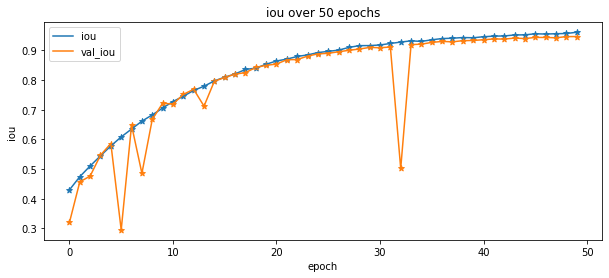

In [ ]:
"""
Show results
"""

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['iou'], label='iou')
plt.scatter(result.epoch, result.history['iou'], marker='*')
plt.plot(result.epoch, result.history['val_iou'], label='val_iou')
plt.scatter(result.epoch, result.history['val_iou'], marker='*')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou over 50 epochs')

plt.show()

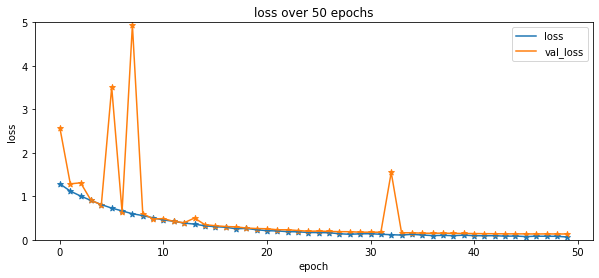

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['loss'], label="loss")
plt.plot(result.epoch, result.history['val_loss'], label="val_loss")
plt.scatter(result.epoch, result.history['loss'], marker='*')
plt.scatter(result.epoch, result.history['val_loss'], marker='*')
plt.legend(loc='upper right')
plt.ylim([0,5])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over 50 epochs')

plt.show()

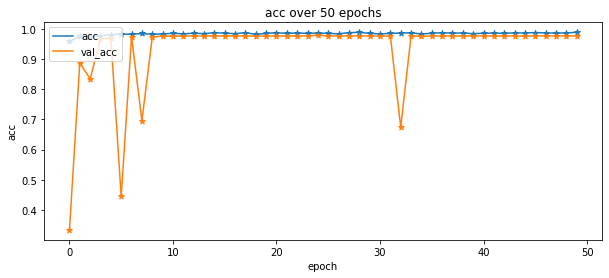

In [ ]:
"""
Show results
"""

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['accuracy'], label='acc')
plt.scatter(result.epoch, result.history['accuracy'], marker='*')
plt.plot(result.epoch, result.history['val_accuracy'], label='val_acc')
plt.scatter(result.epoch, result.history['val_accuracy'], marker='*')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('acc over 50 epochs')

plt.show()

In [ ]:
# save model
!mkdir -p saved_model

model.save('saved_model/DAS_HR_512_model_25epochs')

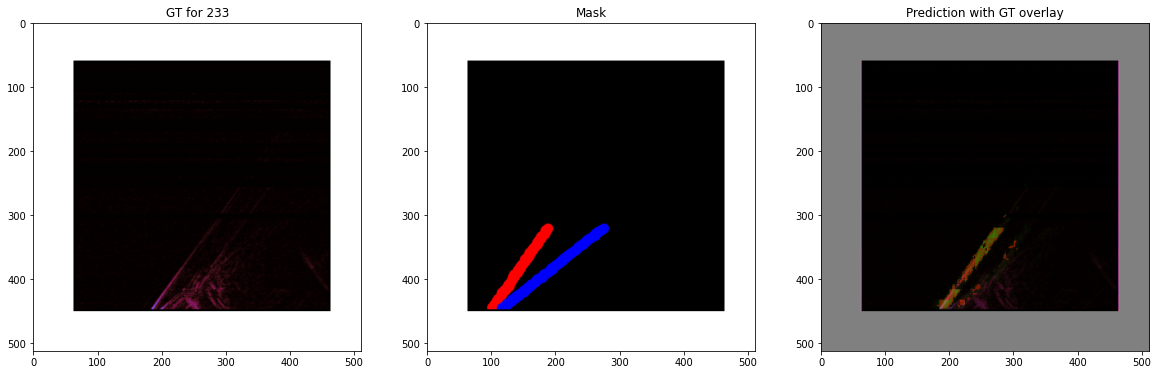

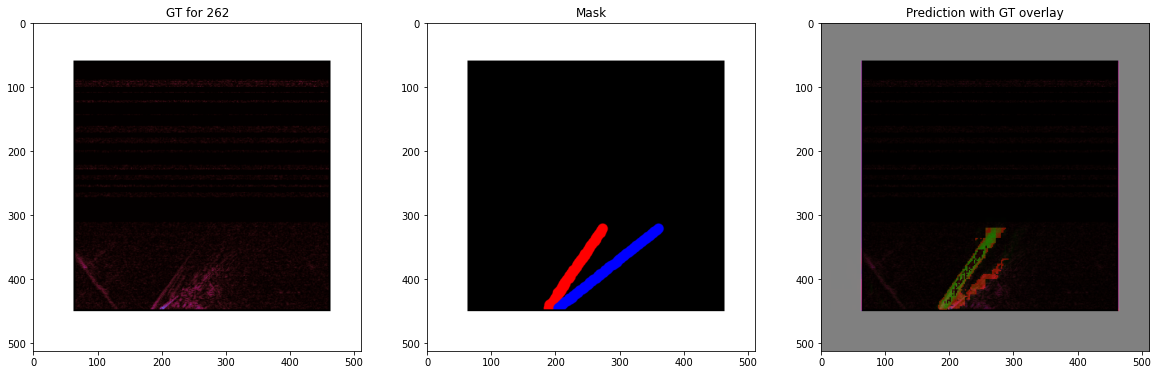

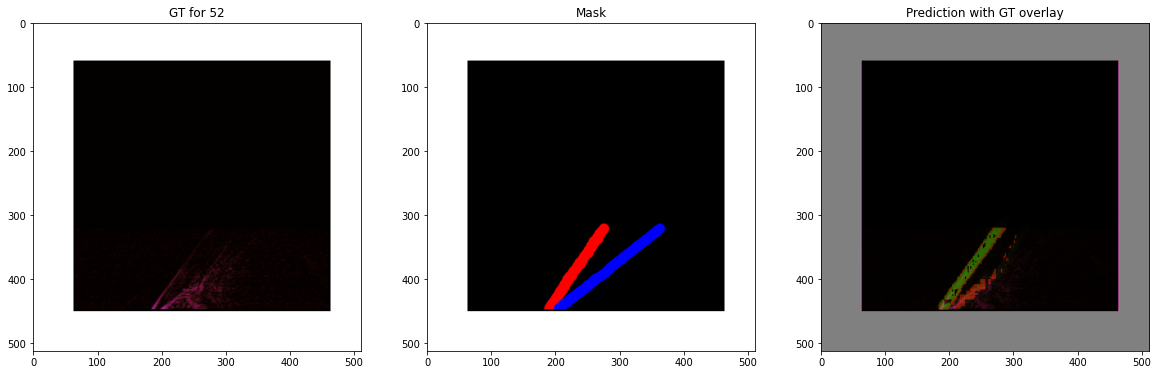

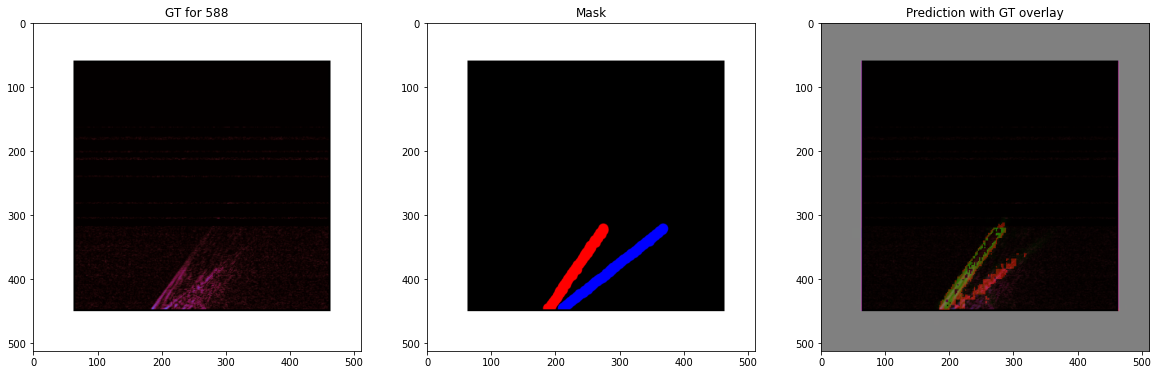

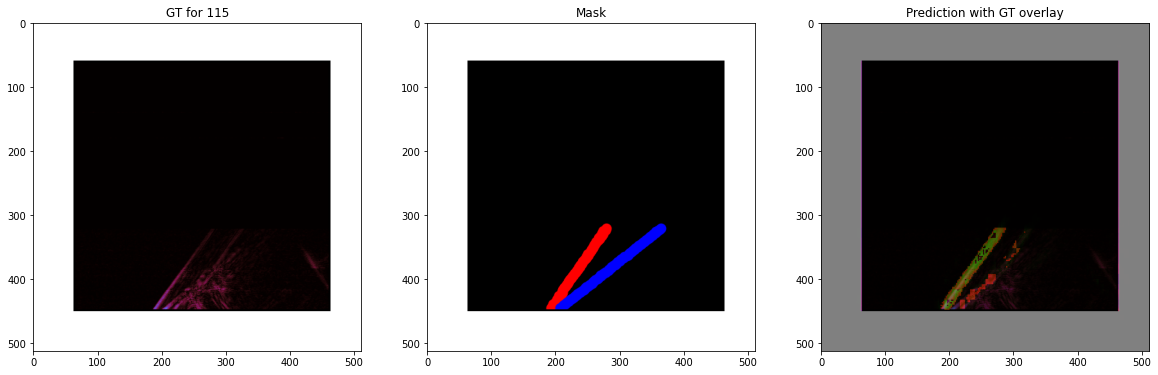

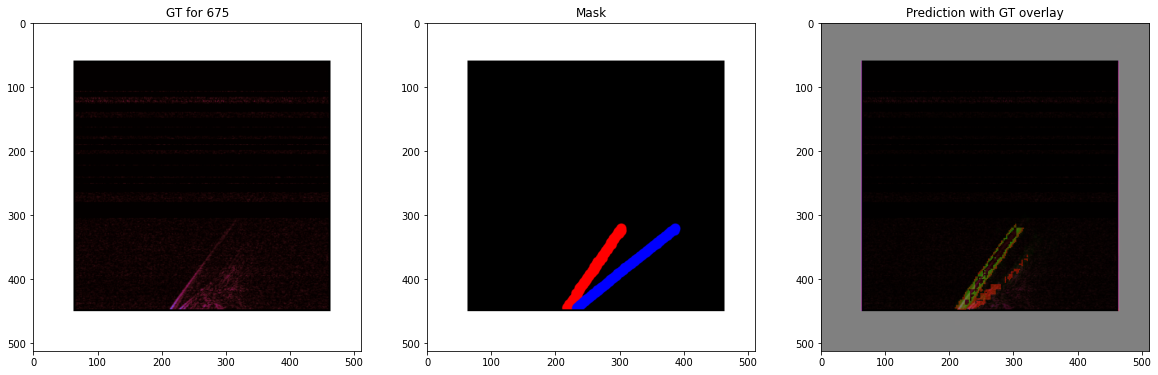

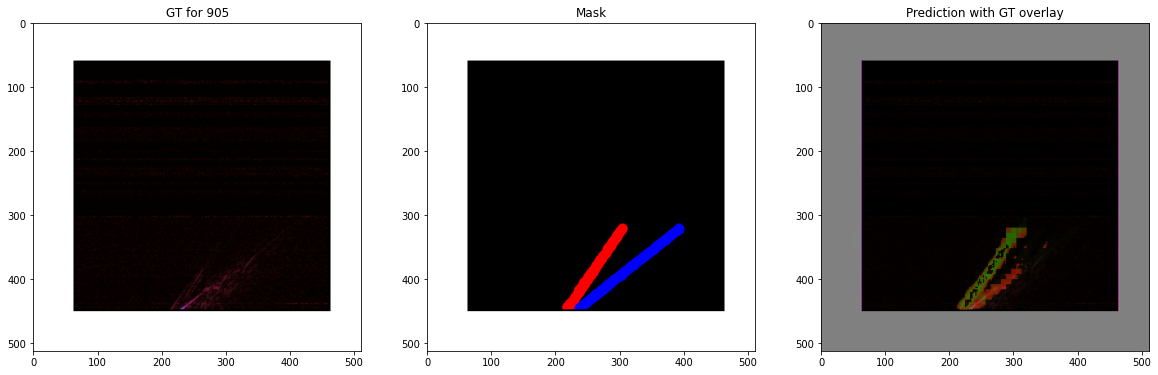

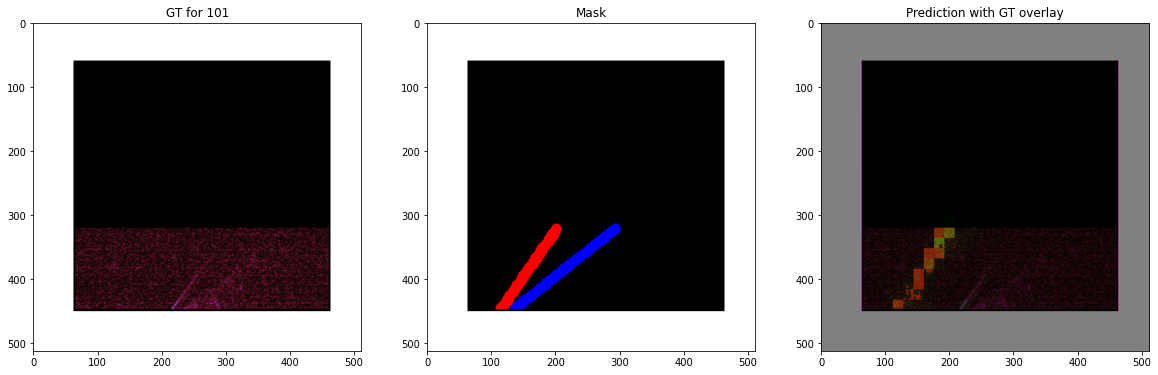

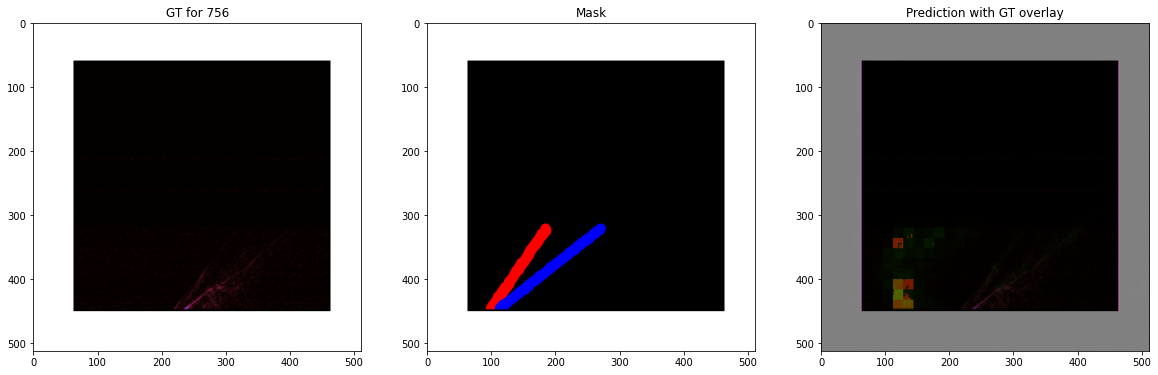

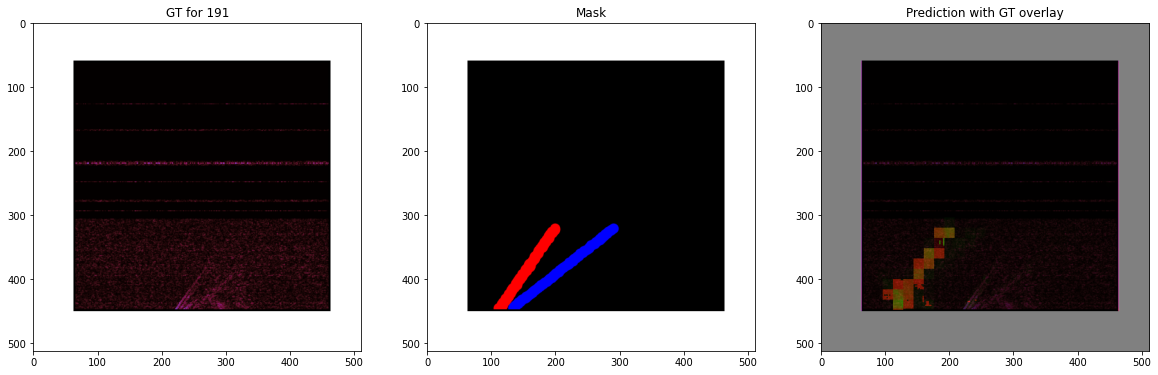

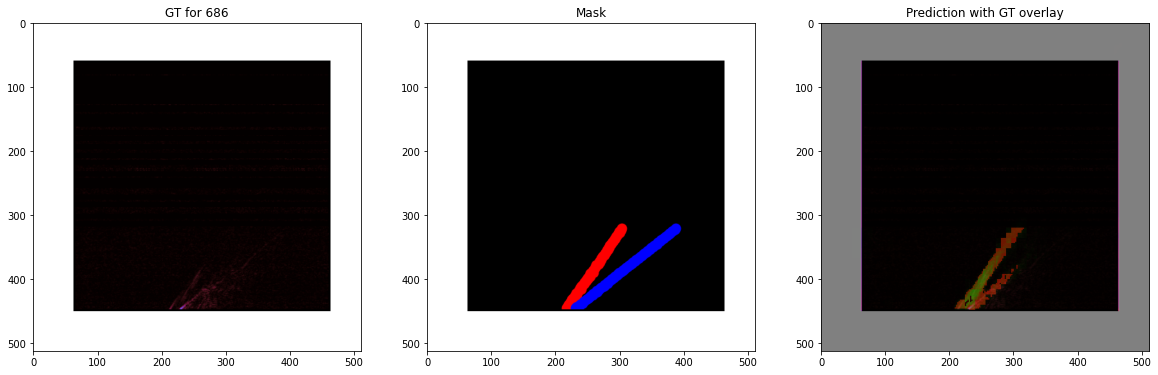

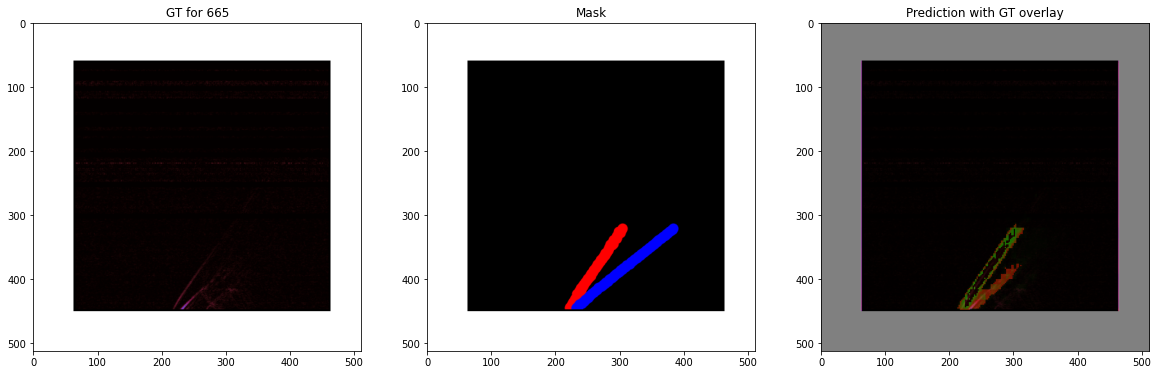

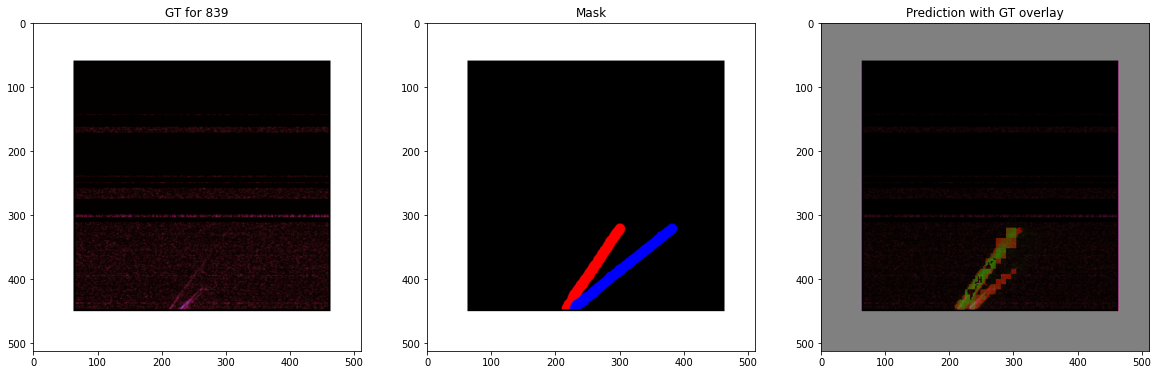

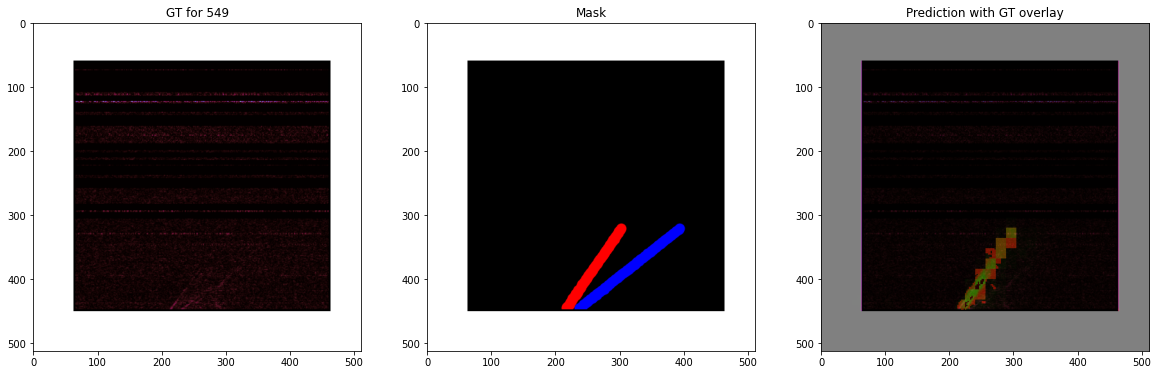

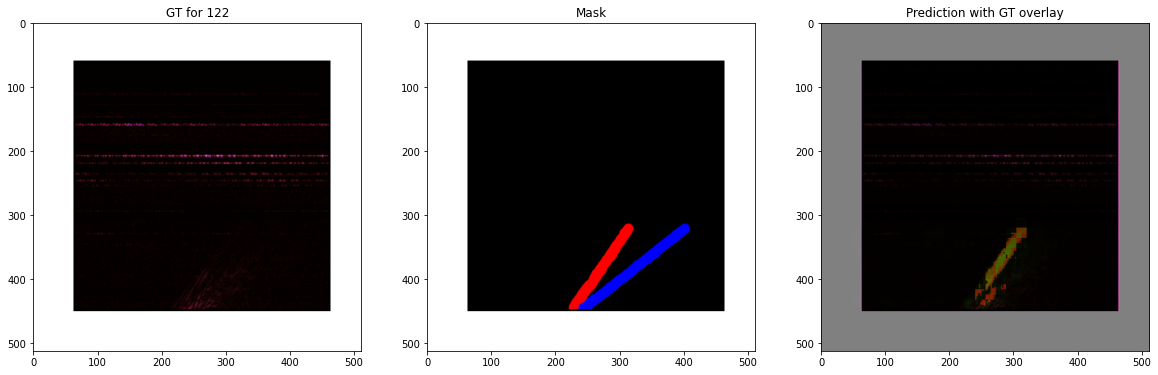

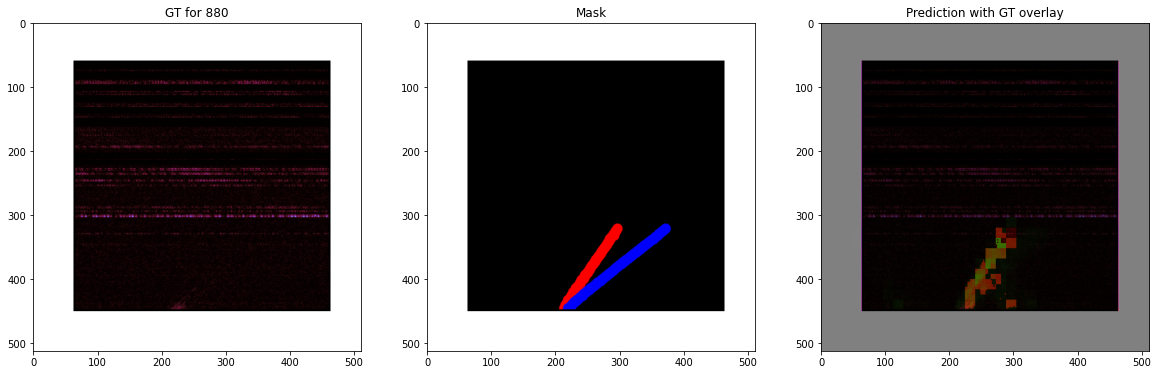

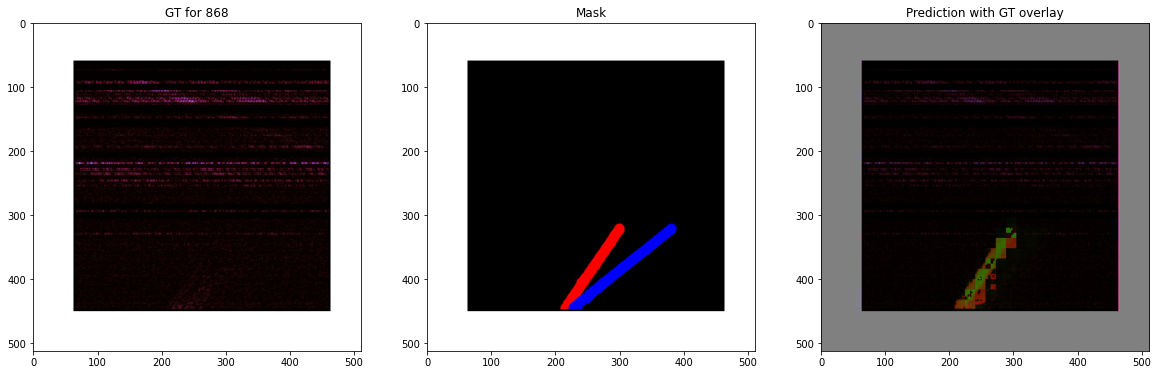

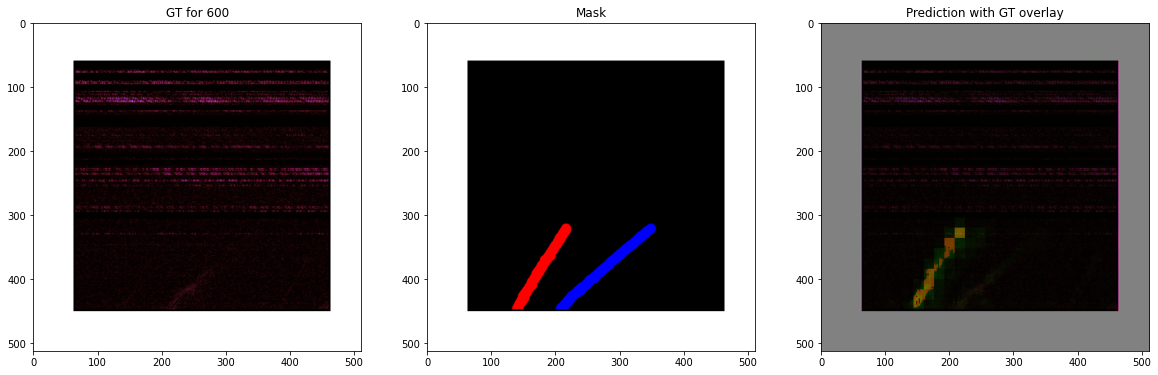

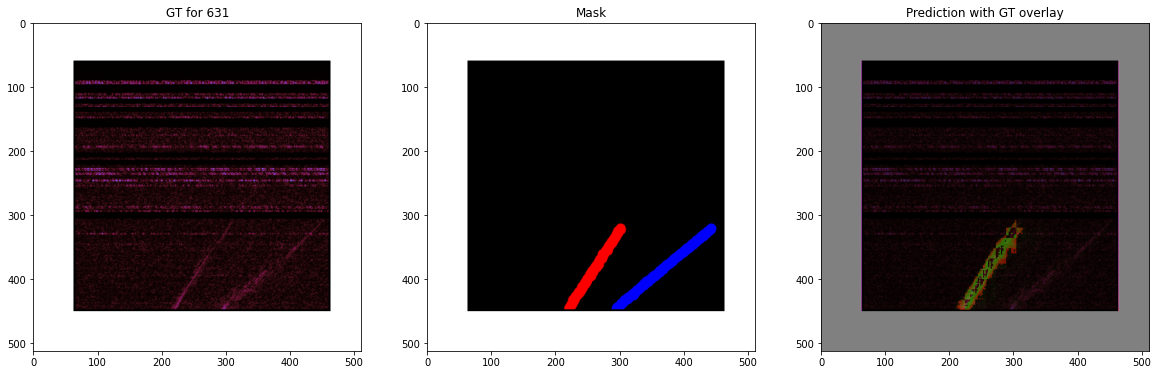

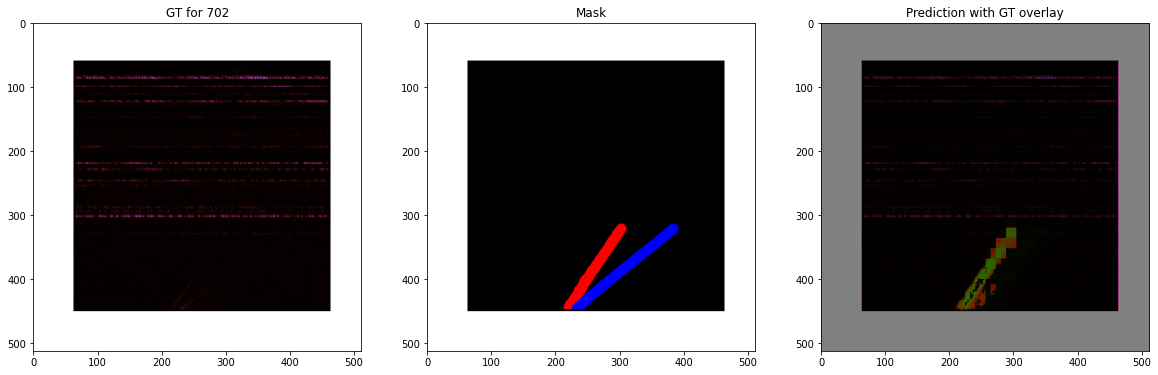

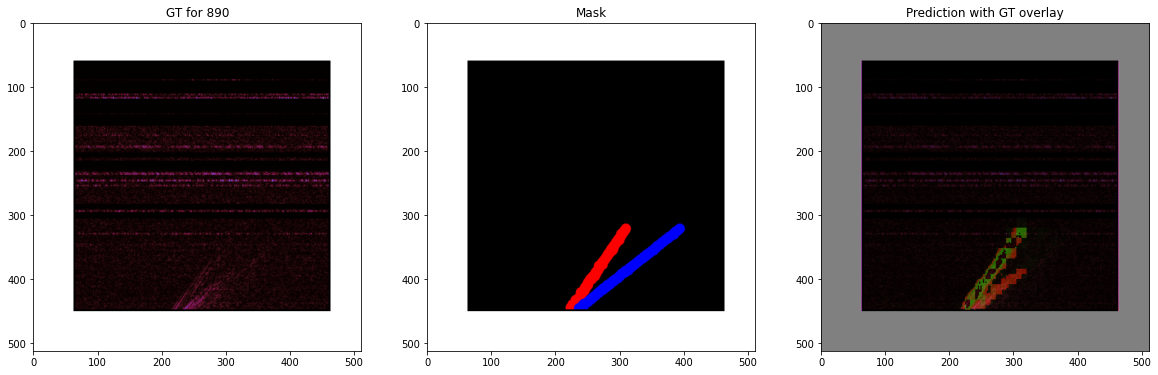

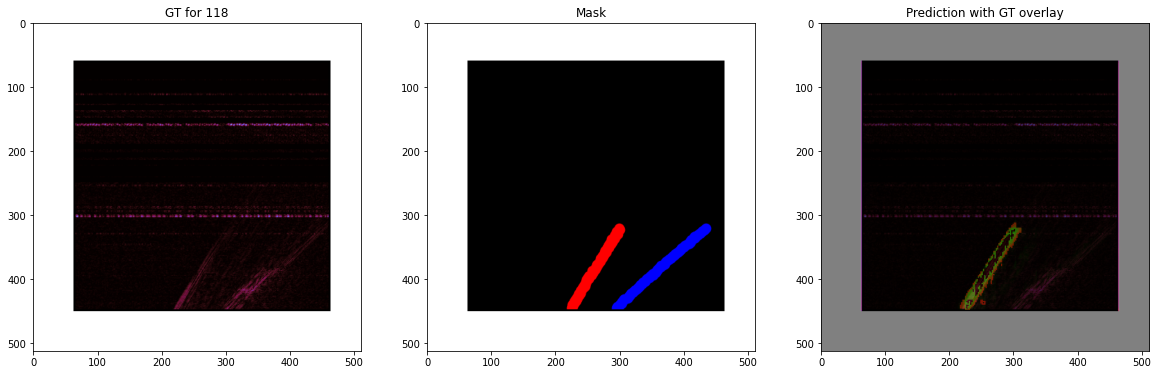

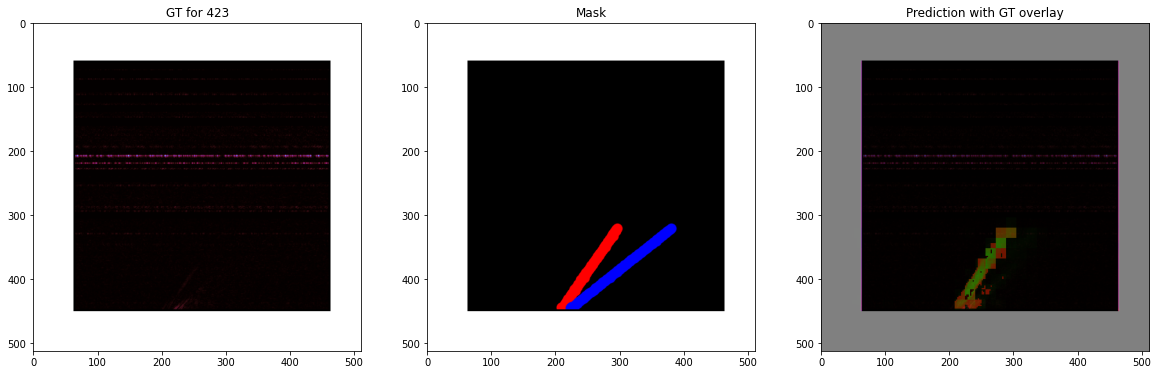

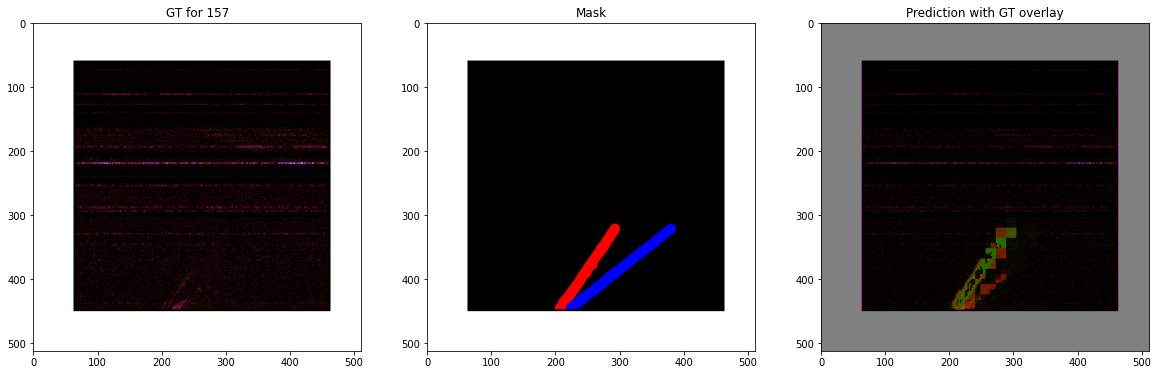

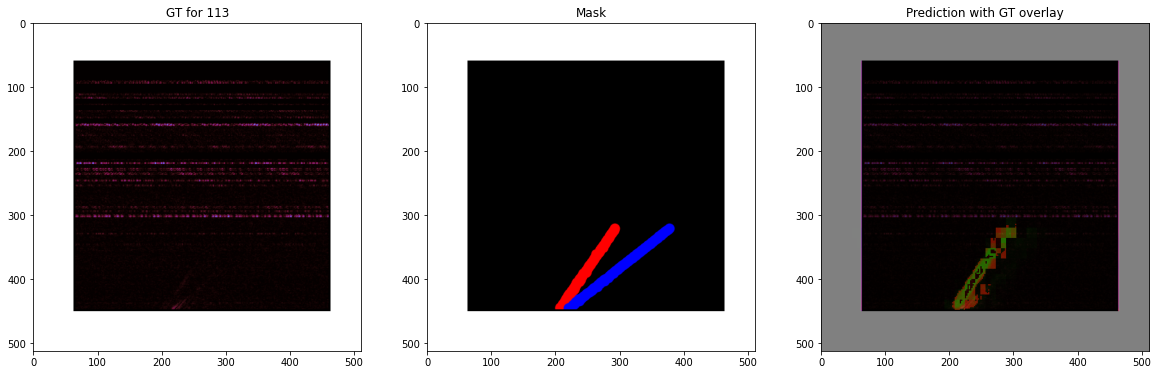

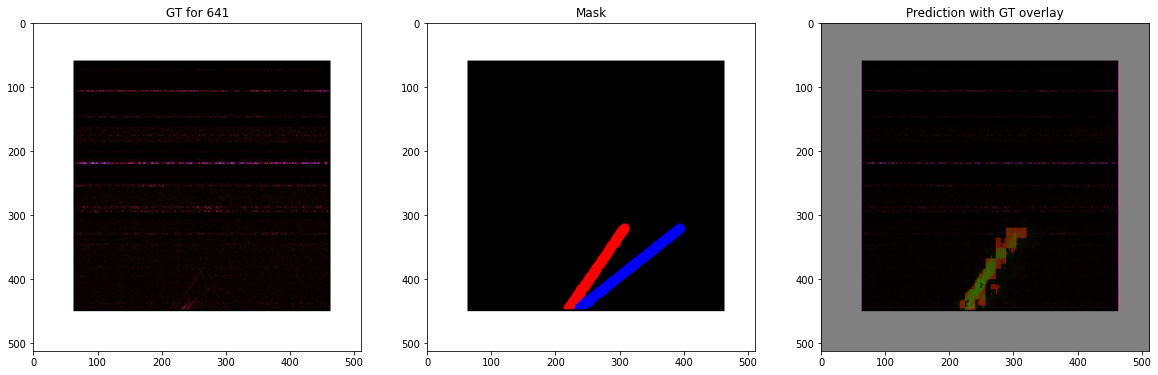

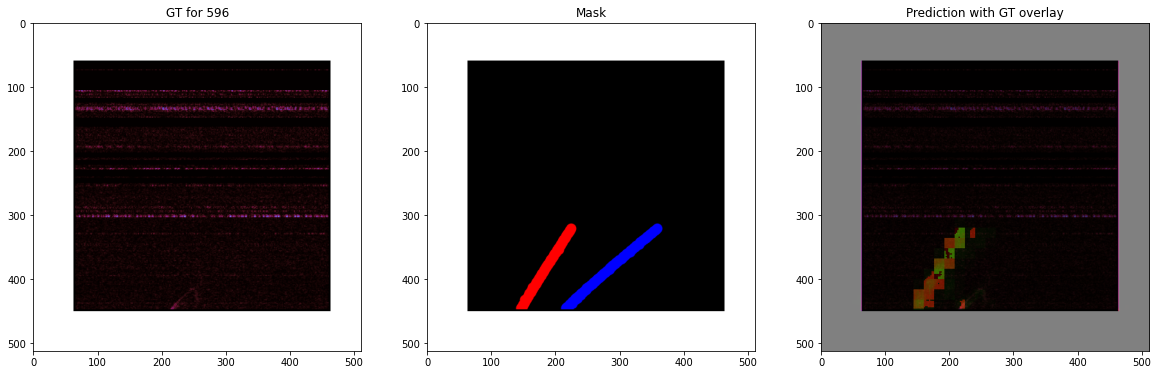

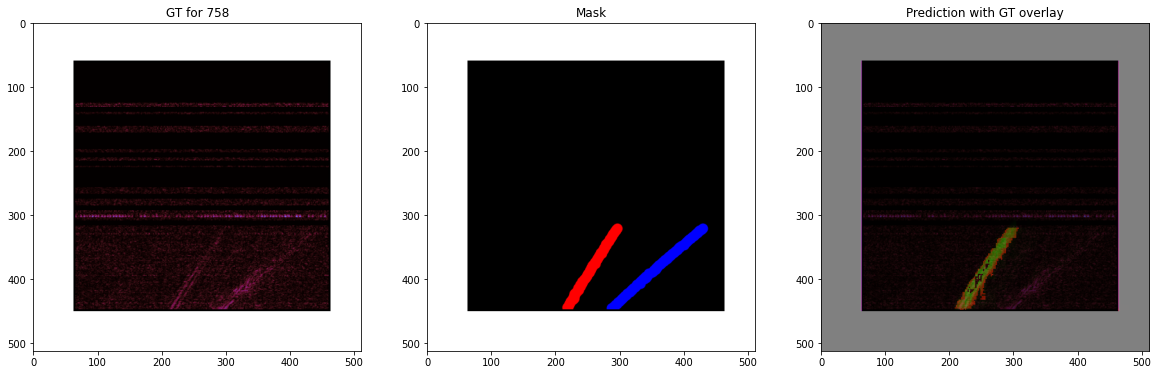

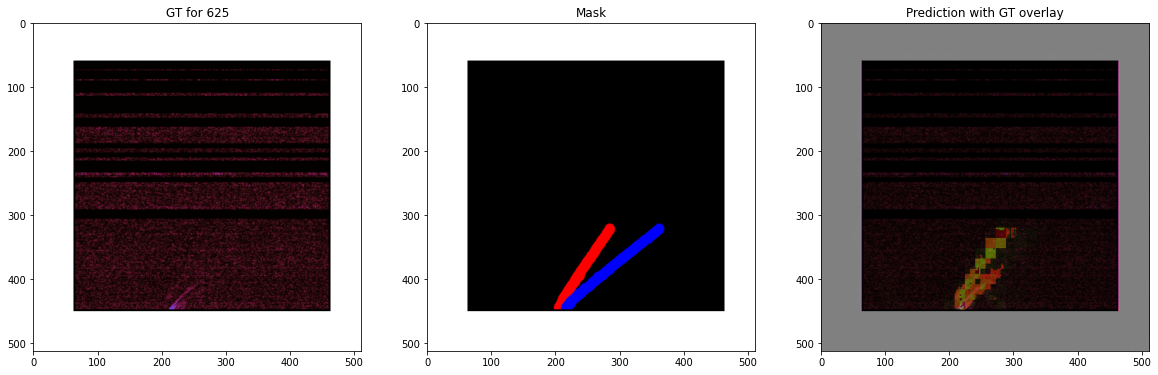

In [ ]:
# tweak rgb thresholds to match prediction with masks

s = 512

def make_mask(pred):
    """ take prediction, each layer is a rbg channel"""

    r = pred[:,:,:,0]
    g = pred[:,:,:,1]
    b = pred[:,:,:,2]

    r_m = np.nanmax(r)
    g_m = np.nanmax(g)
    b_m = np.nanmax(b)

    n_r = (r/r_m).reshape((s,s))
    n_g = (g/g_m).reshape((s,s))
    n_b = (b/b_m).reshape((s,s))

    # set thresholds, manually...

    # n_r[n_r < .65] = 0 #.75
    # n_g[n_g < .66] = 0 #.66
    # n_b[n_b < .47] = 0 #.47

    #n_r[n_r > .99] = 0 #.85
    #n_g[n_g > .99] = 0 #.85
    #n_b[n_b > .99] = 0 #.85

    n_r[n_r > .90] = 0 #.85
    n_g[n_g > .90] = 0 #.85
    n_b[n_b > .90] = 0 #.85


    #return np.dstack((n_r,n_g,n_b))
    return np.dstack((n_r,n_g,n_b))

# test on first 10 random images

for i in range(1,30):

    j = random.randint(0, len(input_img_paths))

    f, axs = plt.subplots(1,3, figsize=(20,20))
    
    eg_file_img = '{}.png'.format(i)
    
    i_path = image_path + eg_file_img
    m_path = mask_path + eg_file_img

    #print('path', i_path)

    #img = cv2.imread(i_path, cv2.COLOR_BGR2RGB)
    #mask = cv2.imread(m_path, cv2.COLOR_BGR2RGB)

    img = cv2.imread(i_path)
    mask = cv2.imread(m_path)
    x = img
    #print('shape of image', np.shape(x))
    
    axs[0].imshow(x)
    axs[2].imshow(x)

    m = mask
    x = x.reshape(1,s,s,3)
    p = model.predict(x)

    axs[1].imshow(m)
    
    axs[2].imshow(make_mask(p), alpha=0.5)

    axs[0].set_title('GT for ' +str(j))
    axs[1].set_title('Mask')
    axs[2].set_title('Prediction with GT overlay')

    plt.show()

In [ ]:
while True:pass
